In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

# Read csv - PV & AC-Consumption
df = pd.read_csv('C:\\Users\\DianaEspinosaLozano\\anaconda3\\envs\\thesis\\elecdemandhourly240723.csv')
hours_per_year = len(df)

# Assuming BS & EV are part of the system
# Battery parameters
battery_capacity = 10  # kWh
c_rate = 1
charge_efficiency = 0.96 # BYD HVS & HVM
discharge_efficiency = 0.96
charging_power = c_rate * battery_capacity * charge_efficiency # kW
min_soc = 1
max_soc = battery_capacity
battery_soc = 5  # Initial state of charge in kWh (50% of battery capacity)

# EV parameters
ev_max_charge_power = 11  # kW, maximum charging power of EV
ev_battery_capacity = 72  # kWh
ev_battery = ev_battery_capacity * 0.5  # Assume 50% initial charge
ev_min_battery_level = ev_battery_capacity * 0.1  # 10% minimum battery
ev_max_battery_level = ev_battery_capacity * 0.8  # 80% max charge level
car_efficiency = 0.191  # kWh/km

# Driver profiles
distance_to_work = 22  # km one way
other_trips_avg = 12  # km

# Adding columns to the DataFrame for the simulation results
df['battery_soc'] = 0.0
df['battery_charge'] = 0.0
df['battery_discharge'] = 0.0
df['grid_export'] = 0.0
df['pv_excess'] = 0.0
df['grid_import'] = 0.0
df['eigenverbrauch'] = 0.0
df['ev_soc'] = 0.0
df['ev_charge'] = 0.0


# Function to generate car availability (home or not) based on the driver profile
def generate_car_availability(homeoffice=True):
    availability = np.ones(hours_per_year)  # Car is at home initially
    weekdays = np.arange(7, hours_per_year, 24)  # Each day starts at 7 am (weekday)
    
    for i in range(0, hours_per_year, 24):  # Loop through each day
        day_of_week = i // 24 % 7
        
        if homeoffice and day_of_week in [1, 3, 5]:  # Mon, Wed, Fri (work from home)
            continue
        elif not homeoffice and day_of_week in range(5):  # Mon-Fri for no homeoffice
            availability[i+7:i+16] = 0  # Not at home from 7 am to 4 pm (commuting to work)
        
        # Random weekend trips
        if day_of_week in [5, 6]:  # Saturday, Sunday
            if np.random.rand() < 0.5:  # Randomly decide if there's a trip
                trip_duration = np.random.randint(2, 8)  # Random duration of trip
                start_hour = np.random.randint(7, 14)  # Random trip starting time
                availability[i+start_hour:i+start_hour+trip_duration] = 0
    return availability

In [ ]:
# Function: Simulation Loop - BS & EV
def simulate_ev_and_bs(homeoffice = True)
    # Generate car availability profile
    car_availability = generate_car_availability(homeoffice)
    df.loc[0, 'battery_soc'] = battery_soc
    # Initial conditions
    ev_battery = max_battery_level

    for hour in range(hours_per_year):
        pv_used_total = 0
        grid_used_total = 0
        bs_used_total = 0
        pv_production = df.loc[hour, 'pv']
        ac_consumption = df.loc[hour, 'h0_dyn'] # Verbrauchsstromprofil
        bs_soc = df['battery_soc'].iloc[hour]

        # Driving consumption logic (for commuting or other trips)
        if car_availability[hour] == 0:  # If car is not at home (driving)
            # Check if driving to work or other random trips
            if hour % 24 == 7:  # Leaving for work at 7 am
                trip_distance = distance_to_work * 2  # To and from work
            else:
                trip_distance = np.random.choice([0, other_trips_avg])
            
        # Deduct battery consumption for driving
        ev_battery -= trip_distance * car_efficiency
        ev_battery = max(ev_battery, min_battery_level)  # Can't go below min battery level

        # Charging logic (if car is at home)
        if car_availability[hour] == 1 and ev_battery < max_battery_level:
            # Check PV surplus and BS state
            pv_surplus = pv_production - ac_consumption
            
            # Check the decision flow for charging (based on the chart)
            if ev_battery < max_battery_level:  # EV battery not full
                charge_power = min(max_charge_power, max_battery_level - ev_battery)  # Cap at max charging power

                if pv_surplus >= 1.4:  # Sufficient PV surplus to charge only from PV
                    charge_power = min(pv_surplus, charge_power)
                    ev_battery += charge_power
                    pv_used_total += charge_power
                    pv_new = pv_surplus - charge_power
                    
                    if pv_new > 0: # Surplus for charging BS
                        charge_potential = pv_new * charge_efficiency
                        charge_to_battery = min(charge_potential, max_soc - bs_soc)
                        # Update battery state of charge
                        bs_soc += charge_to_battery

                        # Calculate excess PV after charging battery
                        pv_excess = pv_new - (charge_to_battery / charge_efficiency)

                        # Energy to be exported to the grid
                        grid_export = pv_excess

                        # Update DataFrame
                        df.loc[hour, 'battery_charge'] = charge_to_battery
                        df.loc[hour, 'grid_export'] = grid_export
                        df.loc[hour, 'pv_excess'] = pv_excess
                        df.loc[hour, 'grid_import'] = 0.0  # No grid import in surplus case
                        df.loc[hour, 'eigenverbrauch'] = ac_consumption
                        df.loc[hour, 'battery_soc'] = bs_soc
                
                elif 0.9 < pv_surplus < 1.4:  # Partial PV + grid charging
                    grid_contribution = 1.4 - pv_surplus  # Amount taken from the grid to reach 1.4 kW
                    charge_power = min(1.4, charge_power)  # Ensure at least 1.4 kW total
                    ev_battery += charge_power
                    pv_used_total += pv_surplus
                    grid_used_total += grid_contribution
                
                elif ev_battery > min_battery_level and ev_battery <= 20:  # Charge from grid if very low
                    charge_power = min(1.4, charge_power)
                    ev_battery += charge_power
                    grid_used_total += charge_power


         # Update results
        df.loc[hour, 'EV_battery'] = ev_battery
        df.loc[hour, 'EV_at_home'] = car_availability[hour]
        df.loc[hour, 'PV_used'] = pv_used_total
        df.loc[hour, 'Grid_used'] = grid_used_total
        df.loc[hour, 'BS_used'] = bs_used_total

    return df

        if pv_production >= ac_consumption:
            # Surplus PV production
            surplus = pv_production - ac_consumption

            # Battery
            # Charge the battery with the surplus, limited by the charging power and max_soc
            charge_potential = surplus * charge_efficiency
            charge_to_battery = min(charge_potential, max_soc - battery_soc)

            # Update battery state of charge
            battery_soc += charge_to_battery

            # Calculate excess PV after charging battery
            pv_excess = surplus - (charge_to_battery / charge_efficiency)

            # Energy to be exported to the grid
            grid_export = pv_excess

            # Update DataFrame
            df.loc[i, 'battery_charge'] = charge_to_battery
            df.loc[i, 'grid_export'] = grid_export
            df.loc[i, 'pv_excess'] = pv_excess
            df.loc[i, 'grid_import'] = 0.0  # No grid import in surplus case
            df.loc[i, 'eigenverbrauch'] = ac_consumption

        else:
            # PV production is less than AC consumption
            shortfall = ac_consumption - pv_production

            # Discharge battery to meet the shortfall, limited by discharging power and min_soc
            discharge_needed = min(shortfall / discharge_efficiency, charging_power)
            discharge_from_battery = min(discharge_needed, battery_soc-min_soc)

            # Actual energy supplied to AC from battery
            energy_from_battery = discharge_from_battery * discharge_efficiency

        
            # Update battery state of charge
            battery_soc -= discharge_from_battery
        
            # Calculate any remaining shortfall after battery discharge
            remaining_shortfall = shortfall - energy_from_battery

            # Energy imported from the grid to cover the remaining shortfall
            grid_import = remaining_shortfall if remaining_shortfall > 0 else 0.0

            # Update DataFrame
            df.loc[i, 'battery_discharge'] = discharge_from_battery
            df.loc[i, 'grid_import'] = grid_import
            df.loc[i, 'grid_export'] = 0.0  # No grid export in deficit case
            df.loc[i, 'pv_excess'] = 0.0  # No excess PV in deficit case
            df.loc[i, 'eigenverbrauch'] = energy_from_battery + pv_production

        # Update SOC in the DataFrame
        df.loc[i, 'battery_soc'] = battery_soc


In [3]:
# Generate car availability profile (0 = not at home, 1 = at home)
car_availability = generate_car_availability(homeoffice=True)  # Assuming homeoffice driver profile

# Simulation loop
for i in range(len(df)):
    pv_production = df.loc[i, 'pv']
    ac_consumption = df.loc[i, 'h0_dyn']  # Household consumption
    car_at_home = car_availability[i]  # Whether the car is at home this hour

    # Calculate available surplus after household consumption
    if pv_production >= ac_consumption:
        pv_surplus = pv_production - ac_consumption
    else:
        pv_surplus = 0

    # Initialize variables for this hour
    ev_charge_power = 0.0
    grid_import = 0.0

    # EV Charging Logic: Prioritize PV surplus for EV, with different conditions
    if car_at_home and ev_battery < ev_max_battery_level:
        # Condition 1: PV surplus ≥ 1.4 kW, charge directly from PV
        if pv_surplus >= 1.4:
            ev_charge_power = min(ev_max_charge_power, pv_surplus, ev_max_battery_level - ev_battery)
            ev_battery += ev_charge_power
            pv_surplus -= ev_charge_power

        # Condition 2: 0.9 < PV surplus < 1.4 kW, supplement with grid
        elif 0.9 < pv_surplus < 1.4:
            # Charge using PV first, then take the rest from the grid to reach 1.4 kW
            ev_charge_power = 1.4  # Target charge power
            ev_charge_from_pv = min(pv_surplus, ev_charge_power, ev_max_battery_level - ev_battery)
            ev_battery += ev_charge_from_pv
            pv_surplus -= ev_charge_from_pv
            if ev_charge_from_pv < 1.4:  # Use grid if PV was insufficient
                grid_import += 1.4 - ev_charge_from_pv

        # Condition 3: If EV battery is low and PV is insufficient, charge from grid
        elif ev_battery > ev_min_battery_level and ev_battery <= ev_battery_capacity * 0.2:
            ev_charge_power = min(ev_max_charge_power, ev_max_battery_level - ev_battery)
            ev_battery += ev_charge_power
            grid_import += ev_charge_power  # Take from grid if PV cannot supply

        df.loc[i, 'ev_charge'] = ev_charge_power

    # Battery Storage Logic (after EV priority)
    if pv_surplus > 0:
        # Charge the home battery with the remaining surplus, limited by charging power and battery capacity
        charge_potential = pv_surplus * charge_efficiency
        charge_to_battery = min(charge_potential, max_soc - battery_soc)

        # Update battery state of charge
        battery_soc += charge_to_battery

        # Calculate remaining PV surplus after charging the battery
        pv_excess = pv_surplus - (charge_to_battery / charge_efficiency)

        # Energy to be exported to the grid
        grid_export = pv_excess

        # Update DataFrame for battery and grid export
        df.loc[i, 'battery_charge'] = charge_to_battery
        df.loc[i, 'grid_export'] = grid_export
        df.loc[i, 'pv_excess'] = pv_excess
        df.loc[i, 'grid_import'] = grid_import  # Grid import already calculated
        df.loc[i, 'eigenverbrauch'] = ac_consumption

    else:
        # If PV is less than consumption, meet the shortfall using the battery or grid
        shortfall = ac_consumption - pv_production

        # Discharge the battery if needed, but limit to charging power and battery SOC
        discharge_needed = min(shortfall / discharge_efficiency, charging_power)
        discharge_from_battery = min(discharge_needed, battery_soc - min_soc)

        # Actual energy supplied to AC from the battery
        energy_from_battery = discharge_from_battery * discharge_efficiency

        # Update battery SOC
        battery_soc -= discharge_from_battery

        # Calculate any remaining shortfall after battery discharge
        remaining_shortfall = shortfall - energy_from_battery

        # Import energy from the grid to cover the remaining shortfall
        grid_import += remaining_shortfall if remaining_shortfall > 0 else 0.0

        # Update DataFrame for battery discharge, grid import, and self-consumption
        df.loc[i, 'battery_discharge'] = discharge_from_battery
        df.loc[i, 'grid_import'] = grid_import
        df.loc[i, 'grid_export'] = 0.0  # No grid export in deficit case
        df.loc[i, 'pv_excess'] = 0.0  # No PV excess in deficit case
        df.loc[i, 'eigenverbrauch'] = energy_from_battery + pv_production

    # Update SOC and EV battery in the DataFrame
    df.loc[i, 'battery_soc'] = battery_soc
    df.loc[i, 'ev_soc'] = ev_battery  # Track EV battery SOC


In [4]:
import datetime
import datetime 
year = 2016 
df.set_index(pd.date_range(datetime.datetime(year, 1, 1, 0), periods= len(df), freq="h"), inplace=True)
df = df.drop(df.columns[0], axis=1)
df

,h0_dyn,pv,sub,Netzbezug,Eigenverbrauch,Einspeisung,battery_soc,battery_charge,battery_discharge,grid_export,pv_excess,grid_import,eigenverbrauch,ev_soc,ev_charge
2016-01-01 00:00:00,0.386959,0.0,-0.386959,0.386959,0.0,0.0,4.596917,0.0,0.403083,0.0,0.0,0.000000,0.386959,36.0,0.0
2016-01-01 01:00:00,0.278753,0.0,-0.278753,0.278753,0.0,0.0,4.306550,0.0,0.290368,0.0,0.0,0.000000,0.278753,36.0,0.0
2016-01-01 02:00:00,0.223167,0.0,-0.223167,0.223167,0.0,0.0,4.074084,0.0,0.232465,0.0,0.0,0.000000,0.223167,36.0,0.0
2016-01-01 03:00:00,0.203622,0.0,-0.203622,0.203622,0.0,0.0,3.861977,0.0,0.212107,0.0,0.0,0.000000,0.203622,36.0,0.0
2016-01-01 04:00:00,0.191801,0.0,-0.191801,0.191801,0.0,0.0,3.662185,0.0,0.199793,0.0,0.0,0.000000,0.191801,36.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,1.061405,0.0,-1.061405,1.061405,0.0,0.0,1.000000,0.0,0.000000,0.0,0.0,1.061405,0.000000,57.6,0.0
2016-12-31 20:00:00,0.868713,0.0,-0.868713,0.868713,0.0,0.0,1.000000,0.0,0.000000,0.0,0.0,0.868713,0.000000,57.6,0.0
2016-12-31 21:00:00,0.677457,0.0,-0.677457,0.677457,0.0,0.0,1.000000,0.0,0.000000,0.0,0.0,0.677457,0.000000,57.6,0.0
2016-12-31 22:00:00,0.618953,0.0,-0.618953,0.618953,0.0,0.0,1.000000,0.0,0.000000,0.0,0.0,0.618953,0.000000,57.6,0.0


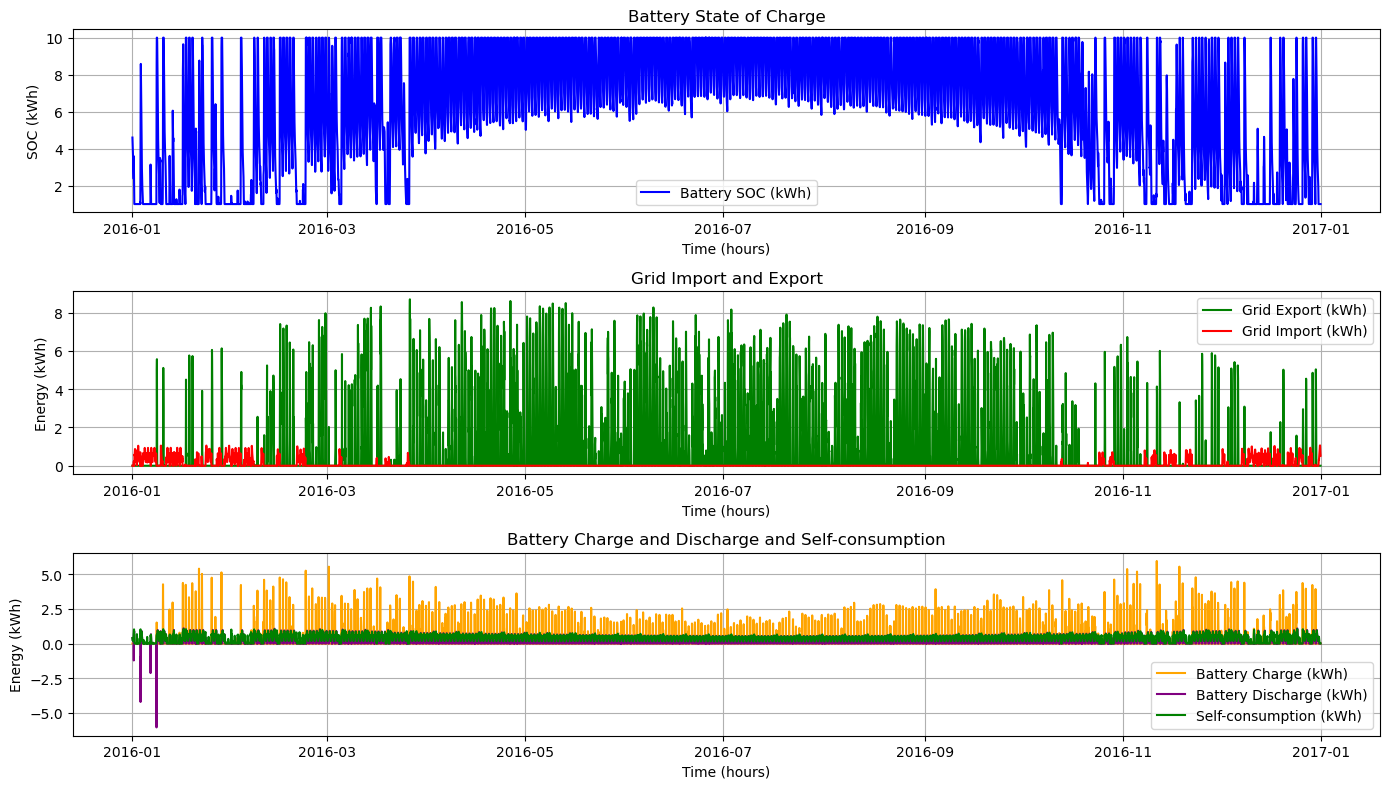

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 8))

# Plot SOC
plt.subplot(3, 1, 1)
plt.plot(df['battery_soc'], label='Battery SOC (kWh)', color='blue')
plt.xlabel('Time (hours)')
plt.ylabel('SOC (kWh)')
plt.title('Battery State of Charge')
plt.legend()
plt.grid(True)

# Plot Grid Import and Export
plt.subplot(3, 1, 2)
plt.plot(df['grid_export'], label='Grid Export (kWh)', color='green')
plt.plot(df['grid_import'], label='Grid Import (kWh)', color='red')
plt.xlabel('Time (hours)')
plt.ylabel('Energy (kWh)')
plt.title('Grid Import and Export')
plt.legend()
plt.grid(True)

# Plot Battery Charge and Discharge
plt.subplot(3, 1, 3)
plt.plot(df['battery_charge'], label='Battery Charge (kWh)', color='orange')
plt.plot(df['battery_discharge'], label='Battery Discharge (kWh)', color='purple')
plt.plot(df['eigenverbrauch'], label = 'Self-consumption (kWh)', color = 'green')
plt.xlabel('Time (hours)')
plt.ylabel('Energy (kWh)')
plt.title('Battery Charge and Discharge and Self-consumption')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [6]:
# Jahresertrag
pv = round(sum(df['pv']))

# Netzbezug
netzbezug = round(sum(df['grid_import']))

# Einspeisung
einspeisung = round(sum(df['grid_export']))

# Eingenverbrauch der PV-Produktion
eigenverbrauch = pv - einspeisung - netzbezug
eigenverbrauch_genau = round(sum(df['eigenverbrauch']))

# Summe der aufgeladener Energie im Batteriespeicher 
batterie = round(sum(df['battery_charge']))

# Direkter Verbrauch an PV-Strom
pv_direkt = eigenverbrauch - batterie

# Stromkosten mit PV
# Strompreis 2024: 41,35 Cent/kWh (https://www.bdew.de/service/daten-und-grafiken/bdew-strompreisanalyse/)
strompreis = 0.4135
stromkosten = round(netzbezug * strompreis, 2)


# Stromkosten ohne PV
verbrauch = round(sum(df['h0_dyn']), 2)
stromkosten_ohne_pv = round(verbrauch * strompreis, 2)

# Einspeisevergütung - Gewinn
# Einspeisevergütung 2024: Feb-Aug: 8,1 ct, Aug-Feb25: 8 ct (https://photovoltaik.org/kosten/einspeiseverguetung)
einspeiseverguetung = 0.08
verguetung = round(einspeisung * einspeiseverguetung, 2)

# Ersparnis
einsparung = round(stromkosten_ohne_pv - (stromkosten - verguetung), 2)

# Print
print('Jahresertrag in kWh: ', pv)
print('Eigenverbrauch in kWh: ', eigenverbrauch)
print('Eigenverbrauch (genau) in kWh: ', eigenverbrauch_genau)
print('Geladene PV-Strom in Batteriespeicher in kWh: ', batterie)
print('Direkter Verbrauch PV-Strom in kWh: ', pv_direkt)
print('')
print('Netzbezug in kWh: ', netzbezug)
print('Einspeisung ins Netz in kWh: ', einspeisung)
print('')
print('Stromkosten ohne PV in €/a: ', stromkosten_ohne_pv)
print('Stromkosten mit PV & BS in €/a: ', stromkosten)
print('Einspeisevergütung in €/a: ', verguetung)
print('Stromkosten Einsparung in €/a: ', einsparung)

Jahresertrag in kWh:  11267
Eigenverbrauch in kWh:  3129
Eigenverbrauch (genau) in kWh:  3496
Geladene PV-Strom in Batteriespeicher in kWh:  1696
Direkter Verbrauch PV-Strom in kWh:  1433

Netzbezug in kWh:  508
Einspeisung ins Netz in kWh:  7630

Stromkosten ohne PV in €/a:  1655.35
Stromkosten mit PV & BS in €/a:  210.06
Einspeisevergütung in €/a:  610.4
Stromkosten Einsparung in €/a:  2055.69


<function matplotlib.pyplot.show(close=None, block=None)>

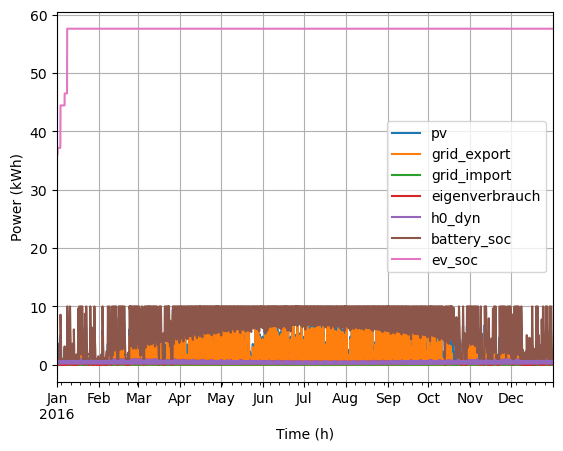

In [12]:
# 1 Tag: 1.1.2016
tag = df.loc['2016-01-01 00:00:00':'2016-12-31 23:00:00', ['pv','grid_export', 'grid_import', 'eigenverbrauch', 'h0_dyn','battery_soc', 'ev_soc']]
tag_plot = tag.plot()
tag_plot.set_xlabel('Time (h)')
tag_plot.set_ylabel('Power (kWh)')
plt.grid(True)
plt.show